In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def embedding_metrics_matrix(path):
    with open(path, 'r') as file:
        data = json.load(file)
    # Extracting the keys that contain the temporal comparisons
    #keys = [key for key in data.keys() if '_' in key]
    keys=['T1_T1', 'T1_T2', 'T1_T3', 'T1_T4', 'T2_T2', 'T2_T3', 'T2_T4', 'T3_T3', 'T3_T4', 'T4_T4']
    # Create an empty matrix for the distances
    matrix_size = 4
    # Assuming it's a square matrix
    #cosine_similarity_matrix = np.zeros((matrix_size, matrix_size))
    cosine_distance_matrix = np.full((matrix_size, matrix_size), np.nan)
    manhattan_distance_matrix = np.full((matrix_size, matrix_size), np.nan)
    euclidean_distance_matrix = np.full((matrix_size, matrix_size), np.nan)
    # Filling the matrices with the corresponding values
    for key in keys:
        i=int(key[1:].split('_T')[1])
        j=int(key[1:].split('_T')[0])
        cosine_distance_matrix[i-1, j-1] = data[key]['metrics']['cosine_distance']
        manhattan_distance_matrix[i-1, j-1] = data[key]['metrics']['manhattan_distance']
        euclidean_distance_matrix[i-1, j-1] = data[key]['metrics']['euclidean_distance']
        cosine_distance_matrix[j-1, i-1] = data[key]['metrics']['cosine_distance']
        manhattan_distance_matrix[j-1, i-1] = data[key]['metrics']['manhattan_distance']
        euclidean_distance_matrix[j-1, i-1]= data[key]['metrics']['euclidean_distance']

    return cosine_distance_matrix,euclidean_distance_matrix,manhattan_distance_matrix

def token_metrics_matrix(path):
    with open(path, 'r') as file:
        data = json.load(file)
    keys=['T1_T1', 'T1_T2', 'T1_T3', 'T1_T4', 'T2_T2', 'T2_T3', 'T2_T4', 'T3_T3', 'T3_T4', 'T4_T4']
    # Create an empty matrix for the distances
    matrix_size = 4
    matrix = np.full((matrix_size, matrix_size), np.nan)
    for key in keys:
        i=int(key[1:].split('_T')[1])
        j=int(key[1:].split('_T')[0])
        matrix[i-1, j-1] = data[key]
        matrix[j-1, i-1] = data[key]
    return matrix


df_name='mimic'
folder_path='/home/weisi/TemporalAssessment/analysis/'


jaccard_path=os.path.join(folder_path,'token_metrics',f'{df_name}_jaccard_results.json')
tfidf_path=os.path.join(folder_path,'token_metrics',f'{df_name}_cosine_tfidf_of_most_freq_tokens.json')
sbert_path=os.path.join(folder_path,'embedding_metrics_and_t-test',f'{df_name}_miniLM_t-test-results.json')
simcse_sup_path=os.path.join(folder_path,'embedding_metrics_and_t-test',f'{df_name}_simcse_sup_t-test-results.json')
simcse_unsup_path=os.path.join(folder_path,'embedding_metrics_and_t-test',f'{df_name}_simcse_unsup_t-test-results.json')
use_path=os.path.join(folder_path,'embedding_metrics_and_t-test',f'{df_name}_use_t-test-results.json')

jaccard_matrix=token_metrics_matrix(jaccard_path)
tfidf_matrix=token_metrics_matrix(tfidf_path)
sbert_cosine_dist_matrix,sbert_euclidean_dist_matrix,sbert_manhattan_dist_matrix=embedding_metrics_matrix(sbert_path)
simcse_sup_cosine_dist_matrix,simcse_sup_euclidean_dist_matrix,simcse_sup_manhattan_dist_matrix=embedding_metrics_matrix(simcse_sup_path)
simcse_unsup_cosine_dist_matrix,simcse_unsup_euclidean_dist_matrix,simcse_unsup_manhattan_dist_matrix=embedding_metrics_matrix(simcse_unsup_path)
use_cosine_dist_matrix,use_euclidean_dist_matrix,use_manhattan_dist_matrix=embedding_metrics_matrix(use_path)

In [2]:
# performance matrixes of bioner:
import os
import json
import numpy as np
import pandas as pd


base_path = "/HDD16TB/weisi/logs"
Task = 'Mimic'

options = ['T1-T1', 'T1-T2', 'T1-T3', 'T1-T4', 'T2-T1','T2-T2', 'T2-T3', 'T2-T4',  'T3-T1', 'T3-T2','T3-T3', 'T3-T4','T4-T1','T4-T2','T4-T3', 'T4-T4']
model_name = 'bert-base-uncased'
seeds = range(1, 6)
metrics = ["predict_micro_f1", "predict_micro_precision", "predict_micro_recall"]

performance_matrices = {metric: np.zeros((4, 4)) for metric in metrics}

for metric in metrics:
    for i in range(1, 5):  # D1 to D4
        for j in range(1, 5):  # D1 to D4
            values = []
            for seed in seeds:
                option = f'T{i}-T{j}'
                file_path = os.path.join(base_path, Task, model_name, option.replace('-', '_'), f"split_seed{seed}", "model_seed_42_3e-5_20epc", "predict_results.json")
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    values.append(data[metric])
            # save 5 seeds mean
            performance_matrices[metric][j-1, i-1] = np.mean(values)
performance_vecs = {metric: matrix.flatten() for metric, matrix in performance_matrices.items()}
'''print(performance_matrices["predict_micro_f1"])
print(performance_matrices["predict_micro_precision"])
print(performance_matrices["predict_micro_precision"])'''

performance_change_matrices = {}
for metric, matrix in performance_matrices.items():
    change_matrix = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            change_matrix[i, j] = matrix[i, j] - matrix[i, i]  
    performance_change_matrices[metric] = change_matrix

performance_change_vecs = {metric: matrix.flatten() for metric, matrix in performance_change_matrices.items()}

performance_change_percentage_matrices = {}
for metric, matrix in performance_matrices.items():
    change_matrix = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            change_matrix[i, j] = (matrix[i, j] - matrix[i, i] )/matrix[i, i] 
    performance_change_percentage_matrices[metric] = change_matrix

'''print(performance_change_percentage_matrices["predict_micro_f1"])
print(performance_change_percentage_matrices["predict_micro_precision"])
print(performance_change_percentage_matrices["predict_micro_precision"])'''

performance_change_percentage_vecs = {metric: matrix.flatten() for metric, matrix in performance_change_percentage_matrices.items()}


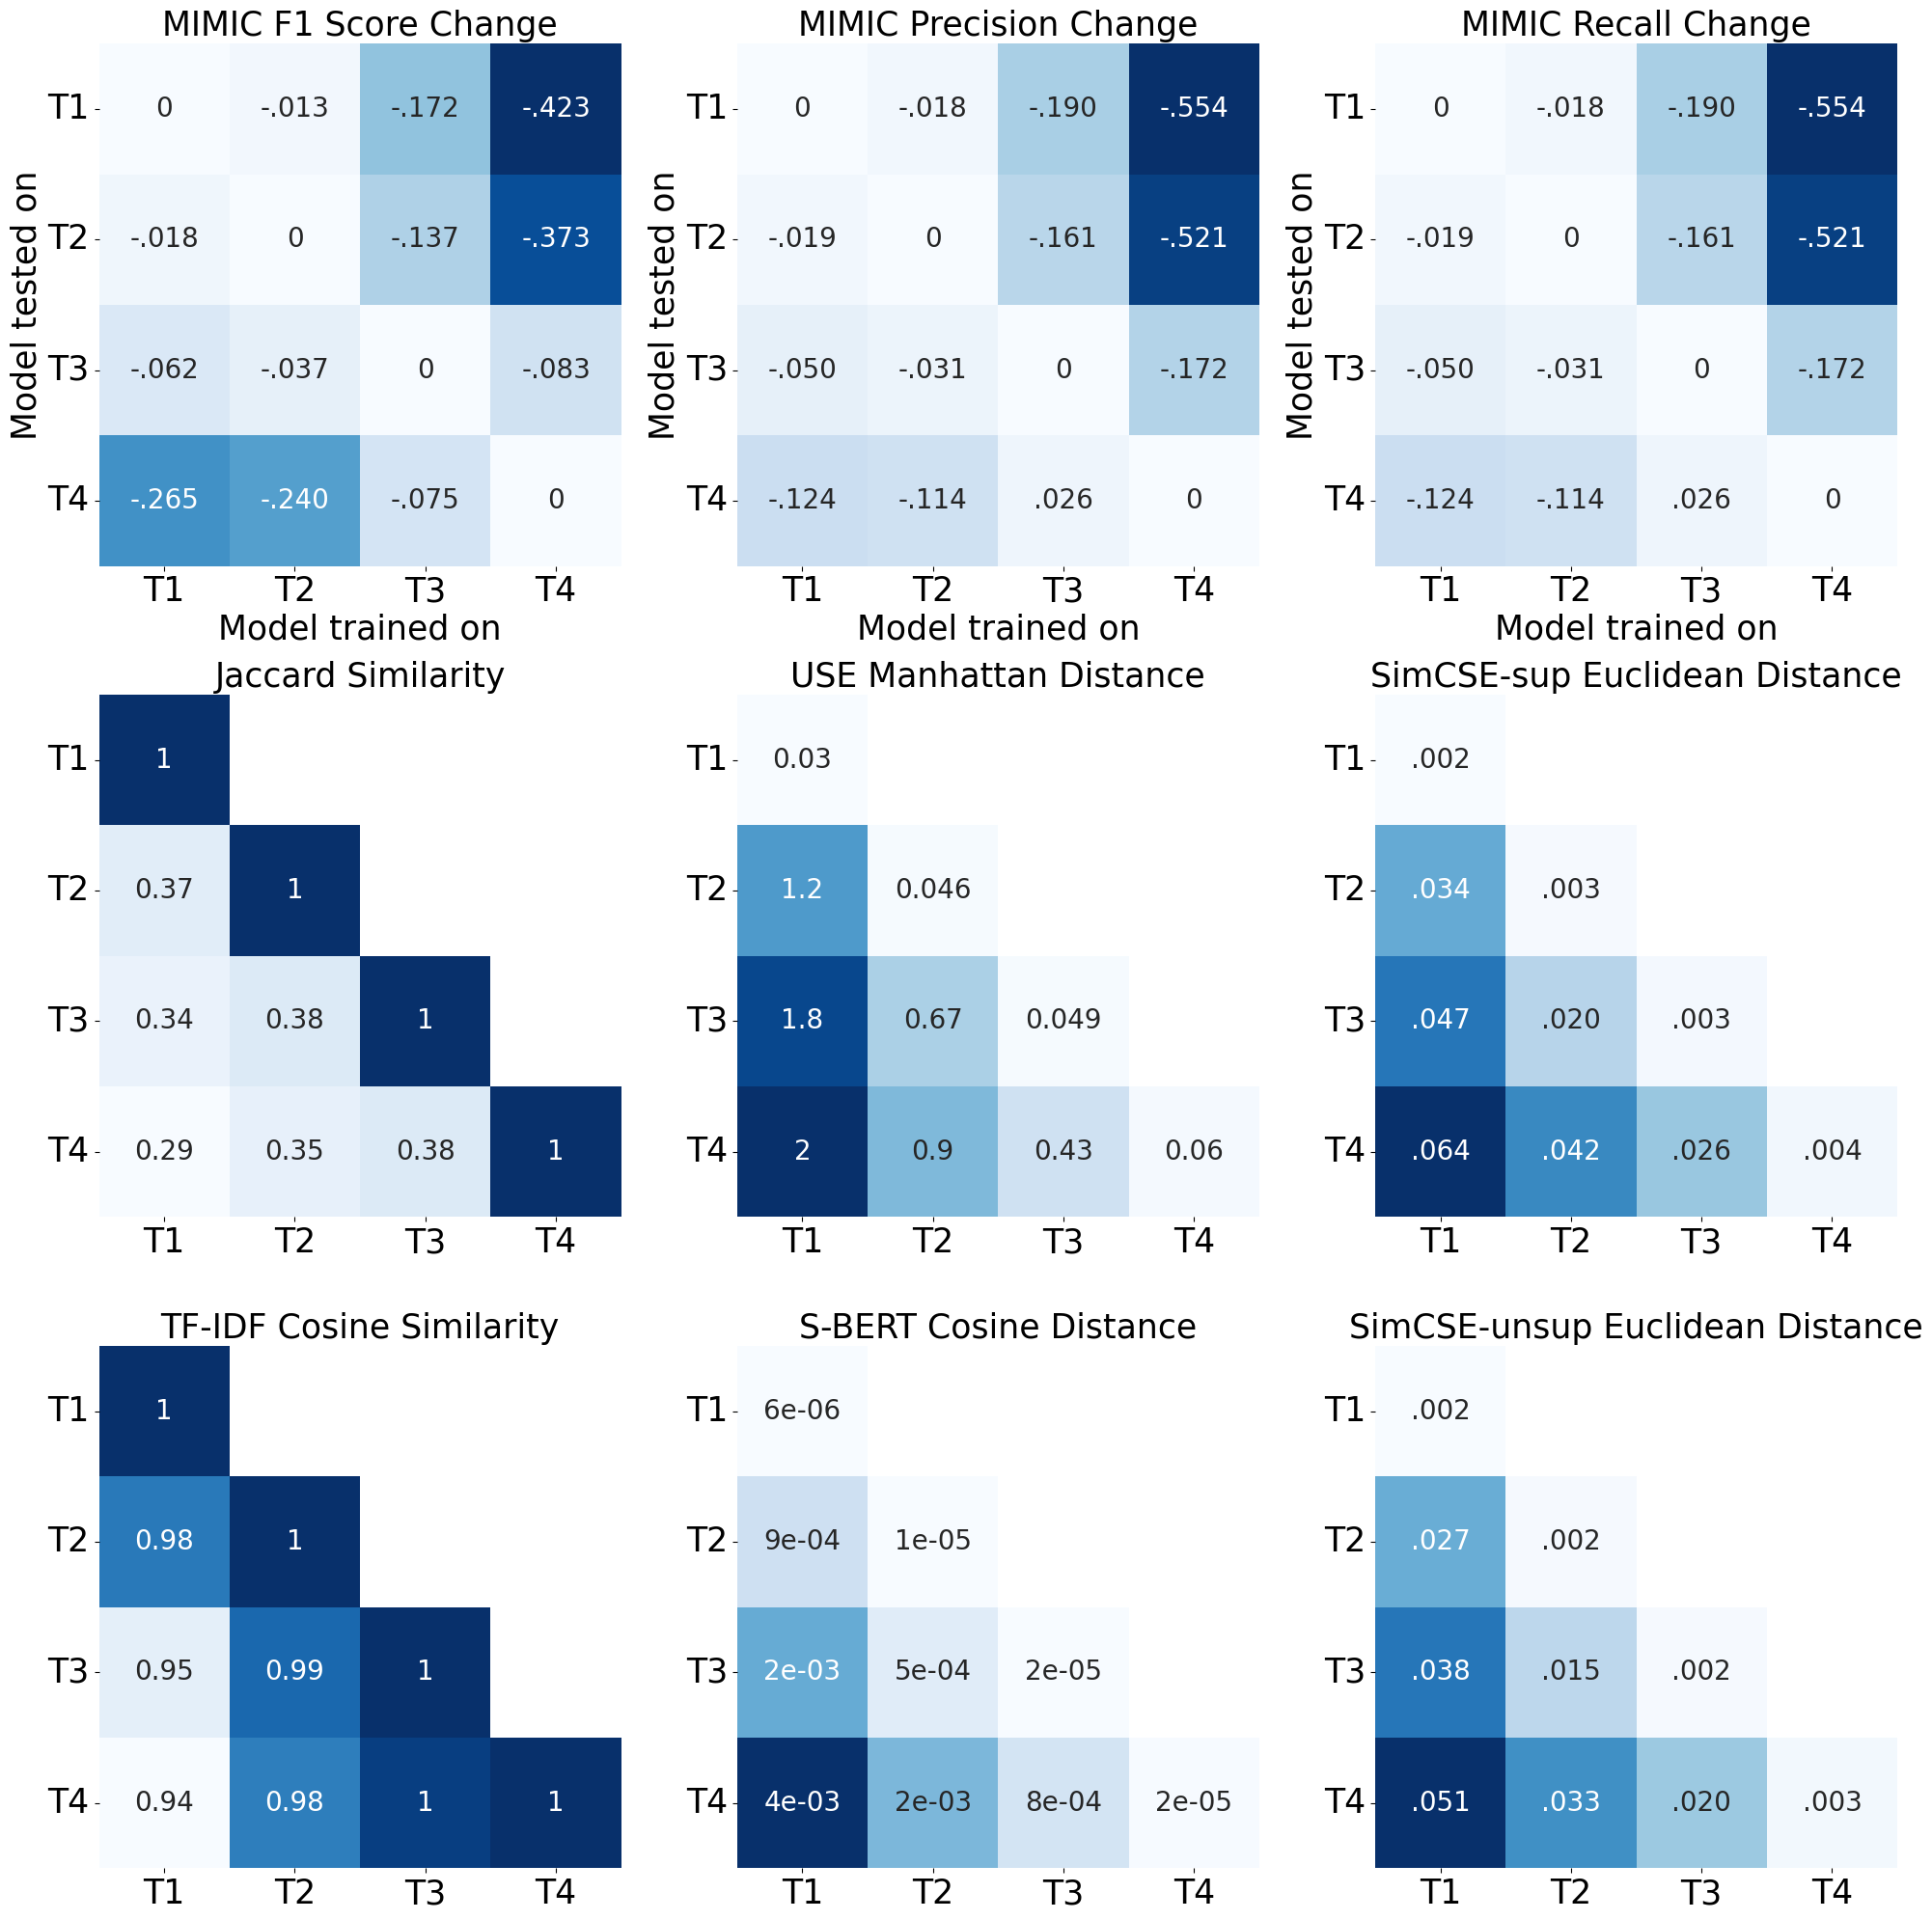

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors



# all matrixes to plot
matrices = [
    performance_change_matrices["predict_micro_f1"],
    performance_change_matrices["predict_micro_precision"],
    performance_change_matrices["predict_micro_precision"],

    jaccard_matrix,
    use_manhattan_dist_matrix,
    simcse_sup_euclidean_dist_matrix,

    tfidf_matrix,
    sbert_cosine_dist_matrix,
    simcse_unsup_euclidean_dist_matrix,
    #sbert_euclidean_dist_matrix,
    #sbert_manhattan_dist_matrix,
    #simcse_sup_cosine_dist_matrix,
    
    #simcse_sup_manhattan_dist_matrix,
    #simcse_unsup_cosine_dist_matrix,
    
    #simcse_unsup_manhattan_dist_matrix,
    #use_cosine_dist_matrix,
    #use_euclidean_dist_matrix,
    
]
'''simcse_sup_cosine_dist_matrix,simcse_sup_euclidean_dist_matrix,simcse_sup_manhattan_dist_matrix=embedding_metrics_matrix(simcse_sup_path)
simcse_unsup_cosine_dist_matrix,simcse_unsup_euclidean_dist_matrix,simcse_unsup_manhattan_dist_matrix=embedding_metrics_matrix(simcse_unsup_path)
use_cosine_dist_matrix,use_euclidean_dist_matrix,use_manhattan_dist_matrix=embedding_metrics_matrix(use_path)'''
# "Performance Change: F1", BioNER Dataset - F1 Score Change
titles = [
    "MIMIC F1 Score Change", 
    "MIMIC Precision Change",
    "MIMIC Recall Change",

    "Jaccard Similarity",
    "USE Manhattan Distance",
    "SimCSE-sup Euclidean Distance",

    "TF-IDF Cosine Similarity",
    "S-BERT Cosine Distance",
    "SimCSE-unsup Euclidean Distance",
    #"S-BERT Euclidean Distance",
    #"S-BERT Manhattan Distance",
    #"SimCSE-sup Cosine Distance",
    
    #"SimCSE-sup Manhattan Distance",
    #"SimCSE-unsup Cosine Distance",
    
    #"SimCSE-unsup Manhattan Distance",
    #"USE Cosine Distance",
    #"USE Euclidean Distance",
    
]


fig, axs = plt.subplots(3, 3, figsize=(20, 20))
tick_labels = ['T1', 'T2', 'T3', 'T4']
title_fontsize = 25 # 标题字体大小
axis_label_fontsize = 25  # 轴标签字体大小
tick_label_fontsize = 25
annot_kws={ "fontsize": 20}
def remove_zero(x):
    if x == 0:
        return "0"
    elif abs(x) < 1:
        return f"{x:.3f}".replace("0.", ".").replace("-0.", "-.")
    else:
        return f"{x:.3f}"
#PuBu RdBu vlag
for i, (matrix, title) in enumerate(zip(matrices, titles)):

    ax = axs[i // 3, i % 3] 
    if i < 3:  # for performance change matrix
        mask = np.zeros_like(matrix, dtype=bool)
        # use abs value to fill color
        sns.heatmap(np.abs(matrix), ax=ax, mask=mask,  fmt='',annot=np.vectorize(remove_zero)(matrix), cmap='Blues', square=True, cbar=False,annot_kws=annot_kws) #, xticklabels=tick_labels, yticklabels=tick_labels)
        #sns.heatmap(matrix, ax=ax, mask=mask, annot=matrix, cmap='Blues', square=True, cbar=False,annot_kws=annot_kws)
        # set x y -labels for sub plot
        ax.set_xlabel('Model trained on', fontsize=axis_label_fontsize)
        ax.set_ylabel('Model tested on', fontsize=axis_label_fontsize)
    elif i%3 ==0: #Jaccard and tfidf
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask, annot=True, cmap='Blues', square=True, cbar=False,cbar_kws={'shrink': .5},annot_kws=annot_kws)
    elif i==7: #3Sbert cos
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask, fmt='',annot=np.vectorize(lambda x: f"{x:.0e}")(matrix), cbar=False, cmap='Blues', square=True, cbar_kws={'shrink': .5},annot_kws=annot_kws)
    elif i==4: # USE manhatan
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask, annot=True, cmap='Blues', square=True,  cbar=False,cbar_kws={'shrink': .5},annot_kws=annot_kws)
    
    else:  # #second and third col
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask,  fmt='',annot=np.vectorize(remove_zero)(matrix),cmap='Blues', square=True,  cbar=False,cbar_kws={'shrink': .5},annot_kws=annot_kws)
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xticklabels(tick_labels, rotation=0, fontsize=tick_label_fontsize)
    ax.set_yticklabels(tick_labels, rotation=0, fontsize=tick_label_fontsize)

plt.tight_layout()
plt.savefig("/home/weisi/TemporalAssessment/analysis/pictures/heatmaps/MIMIC_perf_change_smaller_size.pdf", bbox_inches='tight')
plt.show()

In [17]:
# 假设矩阵已经定义
# matrices_list 包含所有需要计算极值比率的矩阵
matrices_list = [
    jaccard_matrix,
    
    tfidf_matrix,

    sbert_cosine_dist_matrix,
    sbert_euclidean_dist_matrix,
    sbert_manhattan_dist_matrix,

    simcse_sup_cosine_dist_matrix,
    simcse_sup_euclidean_dist_matrix,
    simcse_sup_manhattan_dist_matrix,

    simcse_unsup_cosine_dist_matrix,
    simcse_unsup_euclidean_dist_matrix,
    simcse_unsup_manhattan_dist_matrix,
    
    use_cosine_dist_matrix,
    use_euclidean_dist_matrix,
    use_manhattan_dist_matrix,
]

# 矩阵名称，用于输出结果
matrices_names = [
    "Jaccard Similarity",    
    "TF-IDF Cosine Similarity",

    "S-BERT Cosine Distance",    
    "S-BERT Euclidean Distance",
    "S-BERT Manhattan Distance",
    
    "SimCSE-sup Cosine Distance",
    "SimCSE-sup Euclidean Distance",
    "SimCSE-sup Manhattan Distance",

    "SimCSE-unsup Cosine Distance",
    "SimCSE-unsup Euclidean Distance",
    "SimCSE-unsup Manhattan Distance",

    "USE Cosine Distance",
    "USE Euclidean Distance",
    "USE Manhattan Distance",
]

for name, matrix in zip(matrices_names, matrices_list):
    variability = (np.max(matrix)-np.min(matrix))/ np.max(matrix)
    #extremes_ratio = np.max(matrix) / np.min(matrix)
    #print(f'{name} Extremes Ratio: {extremes_ratio:.3f}')
    print(f'{variability:.3f}')



0.713
0.061
0.999
0.964
0.964
0.999
0.970
0.971
0.999
0.969
0.969
1.000
0.985
0.985


In [16]:
print(use_cosine_dist_matrix)
print(f'{(np.max(use_euclidean_dist_matrix)-np.min(use_euclidean_dist_matrix))/ np.max(use_euclidean_dist_matrix):.3f}')

[[2.54345316e-06 4.16147877e-03 9.92992081e-03 1.18053082e-02]
 [4.16147877e-03 6.09408993e-06 1.42683881e-03 2.52442215e-03]
 [9.92992081e-03 1.42683881e-03 7.09421616e-06 5.55452874e-04]
 [1.18053082e-02 2.52442215e-03 5.55452874e-04 1.04918255e-05]]
0.985


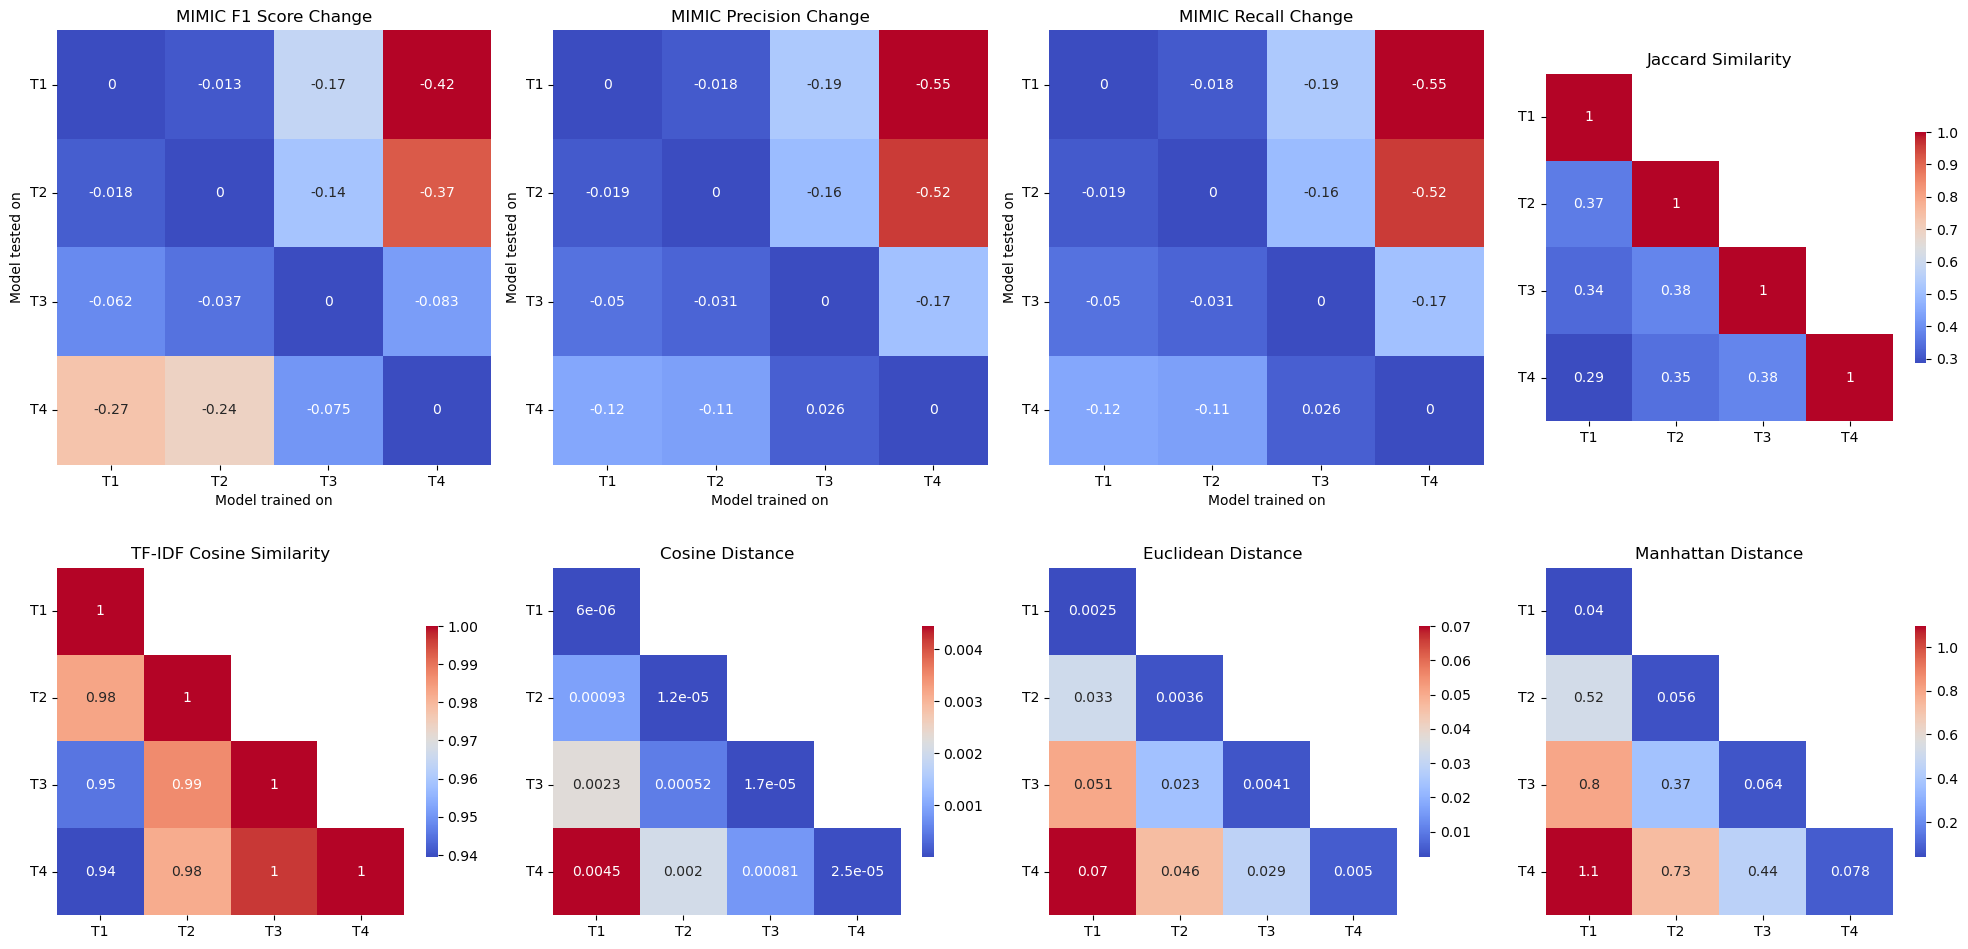

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# all matrixes to plot
matrices = [
    performance_change_matrices["predict_micro_f1"],
    performance_change_matrices["predict_micro_precision"],
    performance_change_matrices["predict_micro_precision"],
    jaccard_matrix,
    tfidf_matrix,
    cosine_dist_matrix,
    euclidean_dist_matrix,
    manhattan_dist_matrix
]

# "Performance Change: F1", BioNER Dataset - F1 Score Change
titles = [
    "MIMIC F1 Score Change", 
    "MIMIC Precision Change",
    "MIMIC Recall Change",
    "Jaccard Similarity",
    "TF-IDF Cosine Similarity",
    "Cosine Distance",
    "Euclidean Distance",
    "Manhattan Distance"
]
'''titles = [
    "MIMIC Performance Change: F1", 
    "MIMIC Performance Change: Precision",
    "MIMIC Performance Change: Recall",
    "Jaccard Similarity",
    "TF-IDF Cosine Similarity",
    "Cosine Distance",
    "Euclidean Distance",
    "Manhattan Distance"
]
'''
# 2*4 subplots

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
tick_labels = ['T1', 'T2', 'T3', 'T4']

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    ax = axs[i // 4, i % 4] 
    if i < 3:  # for performance change matrix
        mask = np.zeros_like(matrix, dtype=bool)
        # use abs value to fill color
        sns.heatmap(np.abs(matrix), ax=ax, mask=mask, annot=matrix, cmap='coolwarm', square=True, cbar=False) #, xticklabels=tick_labels, yticklabels=tick_labels)
        # set x y -labels for sub plot
        ax.set_xlabel('Model trained on')
        ax.set_ylabel('Model tested on')
    else:  # for metrics
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask, annot=True, cmap="coolwarm", square=True, cbar_kws={'shrink': .5})
    
    ax.set_title(title)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.set_yticklabels(tick_labels, rotation=0)

plt.tight_layout()
plt.savefig("/home/weisi/TemporalAssessment/analysis/pictures/MIMIC_perf_change_heatmaps.pdf", bbox_inches='tight')
plt.show()


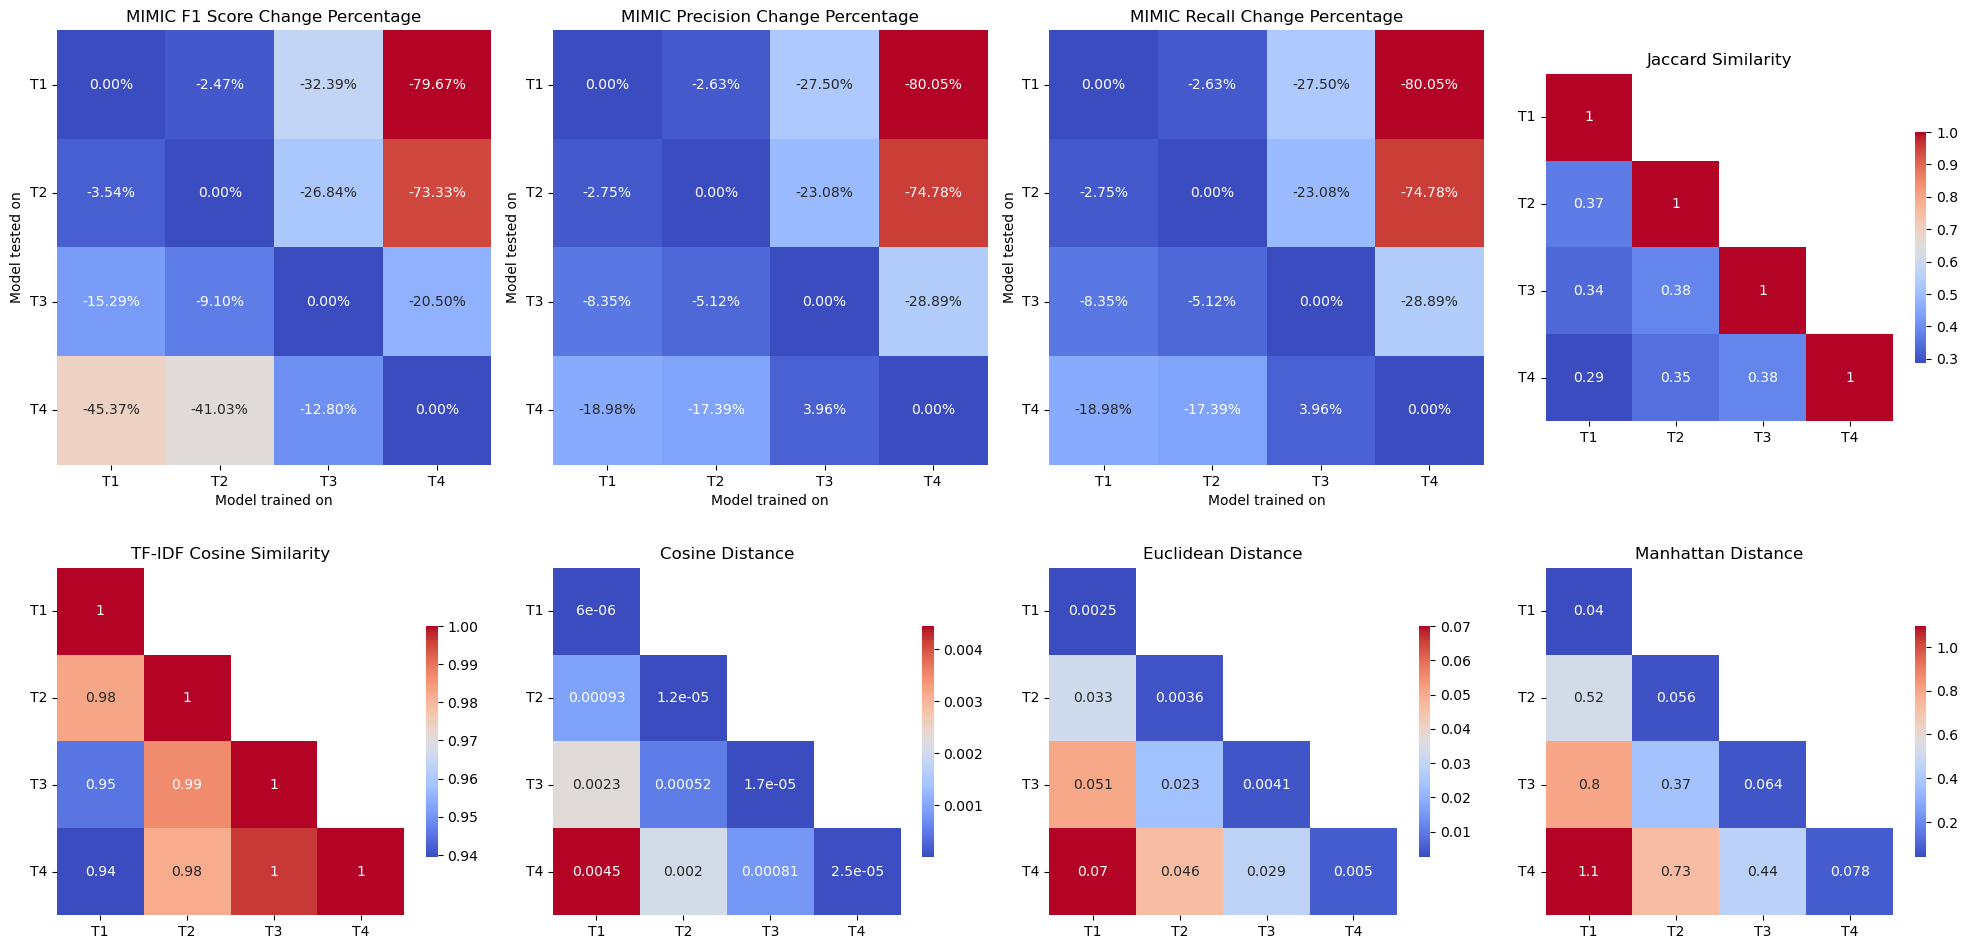

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# all matrixes to plot
matrices = [
    performance_change_percentage_matrices["predict_micro_f1"],
    performance_change_percentage_matrices["predict_micro_precision"],
    performance_change_percentage_matrices["predict_micro_precision"],
    jaccard_matrix,
    tfidf_matrix,
    cosine_dist_matrix,
    euclidean_dist_matrix,
    manhattan_dist_matrix
]

# "Performance Change: F1", BioNER Dataset - F1 Score Change
titles = [
    "MIMIC F1 Score Change Percentage", 
    "MIMIC Precision Change Percentage",
    "MIMIC Recall Change Percentage",
    "Jaccard Similarity",
    "TF-IDF Cosine Similarity",
    "Cosine Distance",
    "Euclidean Distance",
    "Manhattan Distance"
]
# 2*4 subplots

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
tick_labels = ['T1', 'T2', 'T3', 'T4']

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    ax = axs[i // 4, i % 4] 
    if i < 3:  # for performance change matrix
        mask = np.zeros_like(matrix, dtype=bool)
        # use abs value to fill color
        sns.heatmap(np.abs(matrix), ax=ax,mask=mask,fmt='', annot= np.vectorize(lambda x: f"{x:.2f}%")(matrix * 100), cmap='coolwarm', square=True, cbar=False) #, xticklabels=tick_labels, yticklabels=tick_labels)
        # set x y -labels for sub plot
        ax.set_xlabel('Model trained on')
        ax.set_ylabel('Model tested on')
    else:  # for metrics
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
        sns.heatmap(matrix, ax=ax, mask=mask, annot=True, cmap="coolwarm", square=True, cbar_kws={'shrink': .5})
    
    ax.set_title(title)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.set_yticklabels(tick_labels, rotation=0)

plt.tight_layout()
plt.savefig("/home/weisi/TemporalAssessment/analysis/pictures/MIMIC_perf_change_percentage.pdf", bbox_inches='tight')
plt.show()



In [13]:
# performance_matrices = {'f1': predict_micro_f1_matrix, 'precision': predict_micro_precision_matrix, 'recall': predict_micro_recall_matrix}
from scipy.stats import pearsonr
# matrix 2 vector

jaccard_vec = jaccard_matrix.flatten()
tfidf_vec = tfidf_matrix.flatten()

sbert_cos = sbert_cosine_dist_matrix.flatten()
sbert_euc = sbert_euclidean_dist_matrix.flatten()
sbert_man = sbert_manhattan_dist_matrix.flatten()

simcse_sup_cos = simcse_sup_cosine_dist_matrix.flatten()
simcse_sup_euc = simcse_sup_euclidean_dist_matrix.flatten()
simcse_sup_man = simcse_sup_manhattan_dist_matrix.flatten()

simcse_unsup_cos = simcse_unsup_cosine_dist_matrix.flatten()
simcse_unsup_euc= simcse_unsup_euclidean_dist_matrix.flatten()
simcse_unsup_man = simcse_unsup_manhattan_dist_matrix.flatten()
        
use_cos = use_cosine_dist_matrix.flatten()
use_euc = use_euclidean_dist_matrix.flatten()
use_man = use_manhattan_dist_matrix.flatten()
        
# performance_vecs = {metric: matrix.flatten() for metric, matrix in performance_matrices.items()}

dist_vecs = {
    'jaccard_vec':jaccard_vec,
    'tfidf_vec':tfidf_vec,
    'sbert_cos': sbert_cos,
    'sbert_euc': sbert_euc,
    'sbert_man': sbert_man,
    'simcse_sup_cos': simcse_sup_cos,
    'simcse_sup_euc': simcse_sup_euc,
    'simcse_sup_man': simcse_sup_man,
    'simcse_unsup_cos': simcse_unsup_cos,
    'simcse_unsup_euc': simcse_unsup_euc,
    'simcse_unsup_man': simcse_unsup_man,
    'use_cos': use_cos,
    'use_euc': use_euc,
    'use_man': use_man,
    # Add other vectors here
}

# Calculate correlation matrix with p-values
correlation_matrix = {}
p_value_matrix = {}
for metric, perf_vec in performance_change_percentage_vecs.items():
    correlations = {}
    p_values = {}
    for comp_metric, comp_perf_vec in dist_vecs.items():
        r_value, p_value = pearsonr(perf_vec, comp_perf_vec)
        correlations[comp_metric] = r_value
        p_values[comp_metric] = p_value
    correlation_matrix[metric] = correlations
    p_value_matrix[metric] = p_values

# Print correlation matrix with p-values
for metric, correlations in correlation_matrix.items():
    print(f"{metric} performance correlations with:")
    for comp_metric, r_value in correlations.items():
        p_value = p_value_matrix[metric][comp_metric]
        print(f"{comp_metric}: r = {r_value:.3f}, p = {p_value:.4f}")
    print("\n")


predict_micro_f1 performance correlations with:
jaccard_vec: r = 0.580, p = 0.0185
tfidf_vec: r = 0.605, p = 0.0131
sbert_cos: r = -0.804, p = 0.0002
sbert_euc: r = -0.785, p = 0.0003
sbert_man: r = -0.783, p = 0.0003
simcse_sup_cos: r = -0.773, p = 0.0004
simcse_sup_euc: r = -0.758, p = 0.0007
simcse_sup_man: r = -0.754, p = 0.0007
simcse_unsup_cos: r = -0.760, p = 0.0006
simcse_unsup_euc: r = -0.753, p = 0.0008
simcse_unsup_man: r = -0.743, p = 0.0010
use_cos: r = -0.556, p = 0.0253
use_euc: r = -0.593, p = 0.0154
use_man: r = -0.594, p = 0.0152


predict_micro_precision performance correlations with:
jaccard_vec: r = 0.461, p = 0.0726
tfidf_vec: r = 0.477, p = 0.0617
sbert_cos: r = -0.641, p = 0.0075
sbert_euc: r = -0.625, p = 0.0096
sbert_man: r = -0.624, p = 0.0099
simcse_sup_cos: r = -0.617, p = 0.0110
simcse_sup_euc: r = -0.605, p = 0.0131
simcse_sup_man: r = -0.601, p = 0.0138
simcse_unsup_cos: r = -0.605, p = 0.0130
simcse_unsup_euc: r = -0.599, p = 0.0141
simcse_unsup_man: r 

In [10]:
# compute pearson correlation_matrix
correlation_matrix = {}

for metric, perf_vec in performance_change_vecs.items():
    correlations = {
        'jaccard': np.corrcoef(perf_vec, jaccard_vec)[0, 1],
        'tfidf': np.corrcoef(perf_vec, tfidf_vec)[0, 1],
        'cosine_dist': np.corrcoef(perf_vec, cosine_dist_vec)[0, 1],
        'euclidean_dist': np.corrcoef(perf_vec, euclidean_dist_vec)[0, 1],
        'manhattan_dist': np.corrcoef(perf_vec, manhattan_dist_vec)[0, 1]
    }
    correlation_matrix[metric] = correlations

# 
for metric, correlations in correlation_matrix.items():
    print(f"{metric} Performance Change Correlations with:")
    for key, value in correlations.items():
        print(f"{key}: {value}")
    print("\n")

predict_micro_f1 Performance Change Correlations with:
jaccard: 0.5699112949098968
tfidf: 0.6130765937492096
cosine_dist: -0.8225677048300047
euclidean_dist: -0.7941128832296734
manhattan_dist: -0.7918829970447142


predict_micro_precision Performance Change Correlations with:
jaccard: 0.45077519671477834
tfidf: 0.47609436786379306
cosine_dist: -0.6374156032749057
euclidean_dist: -0.6194932345586518
manhattan_dist: -0.6180747713281314


predict_micro_recall Performance Change Correlations with:
jaccard: 0.5885439386762874
tfidf: 0.623887119222293
cosine_dist: -0.8501394344281188
euclidean_dist: -0.8198754396483626
manhattan_dist: -0.8170949853622645




In [11]:
# compute pearson correlation_matrix
correlation_matrix = {}

for metric, perf_vec in performance_change_percentage_vecs.items():
    correlations = {
        'jaccard': np.corrcoef(perf_vec, jaccard_vec)[0, 1],
        'tfidf': np.corrcoef(perf_vec, tfidf_vec)[0, 1],
        'cosine_dist': np.corrcoef(perf_vec, cosine_dist_vec)[0, 1],
        'euclidean_dist': np.corrcoef(perf_vec, euclidean_dist_vec)[0, 1],
        'manhattan_dist': np.corrcoef(perf_vec, manhattan_dist_vec)[0, 1]
    }
    correlation_matrix[metric] = correlations

# 
for metric, correlations in correlation_matrix.items():
    print(f" {metric} Performance change percentage correlations with:")
    for key, value in correlations.items():
        print(f"{key}: {value}")
    print("\n")

 predict_micro_f1 Performance change percentage correlations with:
jaccard: 0.579869511679484
tfidf: 0.6046265496589817
cosine_dist: -0.8035144100544032
euclidean_dist: -0.7849238522983637
manhattan_dist: -0.7825910880741357


 predict_micro_precision Performance change percentage correlations with:
jaccard: 0.4605366171162297
tfidf: 0.47705048819174134
cosine_dist: -0.6408196996302519
euclidean_dist: -0.6252371861016929
manhattan_dist: -0.6235241429091175


 predict_micro_recall Performance change percentage correlations with:
jaccard: 0.6096004561388766
tfidf: 0.6321821774706229
cosine_dist: -0.8372904045359945
euclidean_dist: -0.8200388740404198
manhattan_dist: -0.8174838177381012




                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   16
Model:                            RLM   Df Residuals:                        6
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 10 Mar 2024                                         
Time:                        01:36:05                                         
No. Iterations:                     3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        368.5719    189.076      1.949      0.0

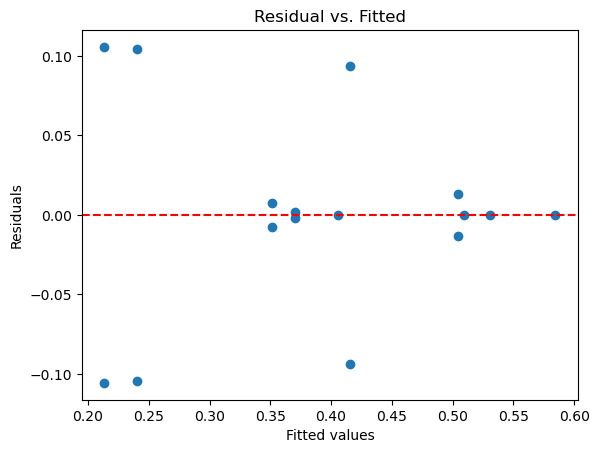

In [75]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid



jaccard_vec = jaccard_matrix.flatten()
tfidf_vec = tfidf_matrix.flatten()

sbert_cos = sbert_cosine_dist_matrix.flatten()
sbert_euc = sbert_euclidean_dist_matrix.flatten()
sbert_man = sbert_manhattan_dist_matrix.flatten()

simcse_sup_cos = simcse_sup_cosine_dist_matrix.flatten()
simcse_sup_euc = simcse_sup_euclidean_dist_matrix.flatten()
simcse_sup_man = simcse_sup_manhattan_dist_matrix.flatten()

simcse_unsup_cos = simcse_unsup_cosine_dist_matrix.flatten()
simcse_unsup_euc= simcse_unsup_euclidean_dist_matrix.flatten()
simcse_unsup_man = simcse_unsup_manhattan_dist_matrix.flatten()
        
use_cos = use_cosine_dist_matrix.flatten()
use_euc = use_euclidean_dist_matrix.flatten()
use_man = use_manhattan_dist_matrix.flatten()

perf_metric = 'predict_micro_f1'   #'predict_micro_recall'  # 'predict_micro_f1'  
y0= performance_matrices[perf_metric].flatten()
y1=performance_change_vecs[perf_metric]
y2=performance_change_percentage_vecs[perf_metric]
'''
predict_micro_f1: 
y0 and X0(all metrics) pvalue works well
y0 and Xcos Xeuc Xman fail (pvalue> 0.9)
y1 and y2 fail with X0 (pvalue> 0.9)
precision and recall fail on some metrics

'''

X0 = np.column_stack([jaccard_vec, tfidf_vec, sbert_cos, sbert_euc, sbert_man,simcse_sup_cos,simcse_sup_euc,simcse_sup_man,simcse_unsup_cos,simcse_unsup_euc,simcse_unsup_man,use_cos,use_euc,use_man])
X0 = sm.add_constant(X0)  


Xcos = np.column_stack([jaccard_vec, tfidf_vec, sbert_cos,simcse_sup_cos,simcse_unsup_cos,use_cos])
Xcos = sm.add_constant(Xcos) 

Xeuc = np.column_stack([jaccard_vec, tfidf_vec, sbert_euc,simcse_sup_euc,simcse_unsup_euc,use_euc])
Xeuc = sm.add_constant(Xeuc) 

Xman = np.column_stack([jaccard_vec, tfidf_vec, sbert_man ,simcse_sup_man ,simcse_unsup_man ,use_man ])
Xman = sm.add_constant(Xman) 

'''model = sm.OLS(y2, X)
results = model.fit()
print(results.summary())'''

model_rlm = sm.RLM(y0, X0 , M=sm.robust.norms.HuberT())
results_rlm = model_rlm.fit()

print(results_rlm.summary())

fig, ax = plt.subplots()
ax.scatter(results_rlm.fittedvalues, results_rlm.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Residual vs. Fitted')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [35]:
print(performance_change_matrices)

{'predict_micro_f1': array([[ 0.        , -0.01311803, -0.17192003, -0.42290621],
       [-0.0180162 ,  0.        , -0.13667803, -0.37345336],
       [-0.06198608, -0.03687517,  0.        , -0.08310224],
       [-0.26516963, -0.23979963, -0.07483756,  0.        ]]), 'predict_micro_precision': array([[ 0.        , -0.01819362, -0.19036864, -0.55417329],
       [-0.01912342,  0.        , -0.1606845 , -0.5206833 ],
       [-0.0497749 , -0.03054881,  0.        , -0.17227114],
       [-0.1244872 , -0.11406922,  0.02597364,  0.        ]]), 'predict_micro_recall': array([[ 0.        , -0.01022763, -0.15109593, -0.34190397],
       [-0.01599437,  0.        , -0.11578624, -0.29071406],
       [-0.05669498, -0.03384276,  0.        , -0.04718963],
       [-0.2988132 , -0.27434421, -0.12020955,  0.        ]])}


In [17]:
perf_metric = 'predict_micro_f1'  
y=performance_change_vecs[perf_metric]
# 创建设计矩阵 X，包含所有指标的向量，加上截距项
X = np.column_stack([jaccard_vec, tfidf_vec, cosine_dist_vec])
X = sm.add_constant(X)  # 添加截距项

# 创建模型并拟合
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     14.17
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           0.000301
Time:                        14:25:23   Log-Likelihood:                 21.557
No. Observations:                  16   AIC:                            -35.11
Df Residuals:                      12   BIC:                            -32.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4654      1.923      2.322      0.0

/home/weisi/anaconda3/envs/tempo0/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [5]:
import statsmodels.api as sm


perf_metric = 'predict_micro_f1'  
y=performance_change_vecs[perf_metric]
# 创建设计矩阵 X，包含所有指标的向量，加上截距项
X = np.column_stack([jaccard_vec, tfidf_vec, cosine_dist_vec, euclidean_dist_vec, manhattan_dist_vec])
X = sm.add_constant(X)  # 添加截距项

# 创建模型并拟合
model_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results_rlm = model_rlm.fit()

print(results_rlm.summary())

NameError: name 'performance_change_vecs' is not defined

In [19]:
import statsmodels.api as sm


perf_metric = 'predict_micro_f1'  
y=performance_change_vecs[perf_metric]
# 创建设计矩阵 X，包含所有指标的向量，加上截距项
X = np.column_stack([jaccard_vec, tfidf_vec, cosine_dist_vec])
X = sm.add_constant(X)  # 添加截距项

# 创建模型并拟合
model_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results_rlm = model_rlm.fit()

print(results_rlm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   16
Model:                            RLM   Df Residuals:                       12
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 07 Mar 2024                                         
Time:                        14:27:03                                         
No. Iterations:                    28                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9720      1.877      2.116      0.0